Training set - 2023 Jan to 2024 March
Input window = 28

#### 1. Import the libraries

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/anaconda/envs/azureml_py38/lib/python3.10/site-packages/numpy-1.23.5.dist-info/METADATA'



2024-11-07 11:42:26.643247: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 11:42:26.659413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730979746.678483    3753 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730979746.684222    3753 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 11:42:26.704488: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
pip install scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


#### 2. Pre processing the dataset

In [5]:
# load dataset
data = pd.read_csv('LL_data.csv')

In [6]:
data.tail()

,Received_Timestamp,Latitude,Longitude
796631,2024-08-16 20:26:55,6.301900,94.509340
796632,2024-08-16 20:41:52,6.304237,94.558950
796633,2024-08-16 20:44:07,6.304650,94.566895
796634,2024-08-16 20:44:45,6.304758,94.569090
796635,2024-08-16 21:01:24,6.306820,94.625694


In [7]:
# Remove the 'Longitude' column
data = data.drop(columns=['Longitude'])

In [8]:
data.tail()

,Received_Timestamp,Latitude
796631,2024-08-16 20:26:55,6.301900
796632,2024-08-16 20:41:52,6.304237
796633,2024-08-16 20:44:07,6.304650
796634,2024-08-16 20:44:45,6.304758
796635,2024-08-16 21:01:24,6.306820


In [9]:
data['Received_Timestamp'] = pd.to_datetime(data['Received_Timestamp'])  # Convert to datetime
data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')       # Convert to numeric, handling errors
#data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')     # Convert to numeric, handling errors
data = data.dropna()  # Drop rows with NaN values if any remain

In [10]:
data.set_index('Received_Timestamp', inplace=True)  # Set datetime as the index

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 796636 entries, 2023-01-01 00:36:49 to 2024-08-16 21:01:24
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Latitude  796636 non-null  float64
dtypes: float64(1)
memory usage: 12.2 MB


In [12]:
# Resample data to six-hour bins, handling empty bins with interpolation
data = data.resample('6H').mean()  # Bin by six hours with mean aggregation
data = data.interpolate(method='linear')  # Linear interpolation for missing bins

/tmp/ipykernel_3753/4293368568.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('6H').mean()  # Bin by six hours with mean aggregation


In [13]:
data.head()

,Latitude
Received_Timestamp,
2023-01-01 00:00:00,23.954669
2023-01-01 06:00:00,23.719084
2023-01-01 12:00:00,23.347651
2023-01-01 18:00:00,23.076742
2023-01-02 00:00:00,22.740178


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2376 entries, 2023-01-01 00:00:00 to 2024-08-16 18:00:00
Freq: 6h
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Latitude  2376 non-null   float64
dtypes: float64(1)
memory usage: 37.1 KB


In [16]:
scaler = MinMaxScaler()
# Ensure 'Latitude' is in a 2D format before scaling
data['Latitude'] = scaler.fit_transform(data[['Latitude']])

In [17]:
# Training set: Entire year of 2023 and up to August 2024
training_set = data.loc['2023':'2024-02']

# Testing set: Remaining months in 2024, starting from September 2024
testing_set = data.loc['2024-03':]


In [18]:
training_set.head()

,Latitude
Received_Timestamp,
2023-01-01 00:00:00,0.545963
2023-01-01 06:00:00,0.543781
2023-01-01 12:00:00,0.540342
2023-01-01 18:00:00,0.537833
2023-01-02 00:00:00,0.534716


In [19]:
testing_set.head()

,Latitude
Received_Timestamp,
2024-03-01 00:00:00,0.541115
2024-03-01 06:00:00,0.548333
2024-03-01 12:00:00,0.559416
2024-03-01 18:00:00,0.570363
2024-03-02 00:00:00,0.581073


#### 3. Sliding window approach

In [20]:
# Define the input window size (20 data points)
input_window_size = 28
# Define the output window size (1 data point)
output_window_size = 1
# Define the stride, which determines how much to move forward for each new window (1 data point)
stride = 1

In [21]:
# Apply sliding window to create sequences
# Initialize empty lists to store the input (X) and output (y) sequences
X, y = [], []

# Loop through the dataset to create windows of input and output sequences
for i in range(0, len(training_set) - input_window_size - output_window_size + 1, stride):
    # Define the input window, which is a slice of 20 data points
    input_window = training_set.iloc[i:i+input_window_size][['Latitude']]
    # Define the output window, which is a slice of 1 data point immediately following the input window
    output_window = training_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Latitude']]
    # Append the input window data to X and the last value of output window to y
    X.append(input_window.values)
    y.append(output_window.values[-1])

In [22]:
# Convert X and y lists to numpy arrays for model input
X, y = np.array(X), np.array(y)

# Print the number of samples created
print(f"Number of samples: {X.shape[0]}")
# Print the shape of the input (X) and output (y) arrays
print(f"Input shape: {X.shape}, Target shape: {y.shape}")

Number of samples: 1672
Input shape: (1672, 28, 1), Target shape: (1672, 1)


#### 4. Define LSTM model architecture

In [23]:
# Import necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define a function to create an LSTM model with specified hyperparameters
def build_model(units=50, lstm_layers=2, dropout_rate=0.2, recurrent_dropout=0.2, activation='tanh', learning_rate=0.001):
    """
    Builds an LSTM model with the given parameters.

    Parameters:
        units (int): Number of units in each LSTM layer.
        lstm_layers (int): Number of stacked LSTM layers.
        dropout_rate (float): Dropout rate for regularization.
        recurrent_dropout (float): Dropout rate for the recurrent connections.
        activation (str): Activation function for LSTM layers.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model (Sequential): Compiled Keras model ready for training.
    """
    # Initialize a Sequential model
    model = Sequential()
    
    # Add LSTM layers
    for i in range(lstm_layers - 1):
        # Add intermediate LSTM layers with return_sequences=True for stacking
        model.add(LSTM(units=units, activation=activation, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
    
    # Add the final LSTM layer without return_sequences, as this is a many-to-one model
    model.add(LSTM(units=units, activation=activation, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
    
    # Add a Dense layer with 1 unit for output (for regression)
    model.add(Dense(1))
    
    # Initialize the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model using mean squared error (MSE) as the loss function, which is suitable for regression
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

# Initialize variables to keep track of the best model and lowest validation loss
best_model = None
best_loss = float('inf')  # Start with a high initial loss for comparison

# Define hyperparameter grids for tuning
units_list = [50, 100, 150]       # Different numbers of units to try in LSTM layers
layers_list = [1, 2, 3]           # Different numbers of LSTM layers to try
dropout_list = [0.2, 0.3, 0.5]    # Different dropout rates to test for regularization
learning_rates = [0.0001, 0.001, 0.005]  # Different learning rates for the optimizer
batch_sizes = [16, 32, 48]        # Different batch sizes for training

# Perform grid search across all combinations of hyperparameters
for units in units_list:
    for layers in layers_list:
        for dropout in dropout_list:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    # Print the current combination of hyperparameters being tested
                    print(f"Training model with units={units}, layers={layers}, dropout={dropout}, lr={lr}, batch_size={batch_size}")
                    
                    # Build a model with the current set of hyperparameters
                    model = build_model(units=units, lstm_layers=layers, dropout_rate=dropout, learning_rate=lr)
                    
                    # Define early stopping to stop training if validation loss doesn't improve for a number of epochs
                    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                    
                    # Define learning rate scheduler to reduce learning rate if validation loss plateaus
                    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
                    
                    # Train the model on the data with a validation split of 30%
                    # Early stopping and learning rate scheduler will be used as callbacks
                    history = model.fit(X, y, 
                                        epochs=100, 
                                        batch_size=batch_size, 
                                        validation_split=0.3, 
                                        callbacks=[early_stopping, lr_scheduler], 
                                        verbose=1)
                    
                    # Retrieve the minimum validation loss achieved during training
                    val_loss = min(history.history['val_loss'])
                    
                    # Check if the current model has achieved a lower validation loss than the best so far
                    if val_loss < best_loss:
                        # Update the best model and best loss
                        best_loss = val_loss
                        best_model = model
                        best_params = (units, layers, dropout, lr, batch_size)
                        best_history = history

# At the end of the search, 'best_model' contains the model with the lowest validation loss
# 'best_params' holds the parameters that yielded the best model, and 'best_history' contains the training history


Training model with units=50, layers=1, dropout=0.2, lr=0.0001, batch_size=16
Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2194 - val_loss: 0.0452 - learning_rate: 1.0000e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0627 - val_loss: 0.0063 - learning_rate: 1.0000e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0353 - val_loss: 0.0062 - learning_rate: 1.0000e-04
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0344 - val_loss: 0.0068 - learning_rate: 1.0000e-04
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0226 - val_loss: 0.0088 - learning_rate: 1.0000e-04
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0178 - val_loss: 0.0104 - learning_rate: 5.0000e-05
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0141 - val_loss: 0.0124 - learning_rate: 5.0000e-05
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0112 - val_loss: 0.01

2024-11-07 11:49:56.853761: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


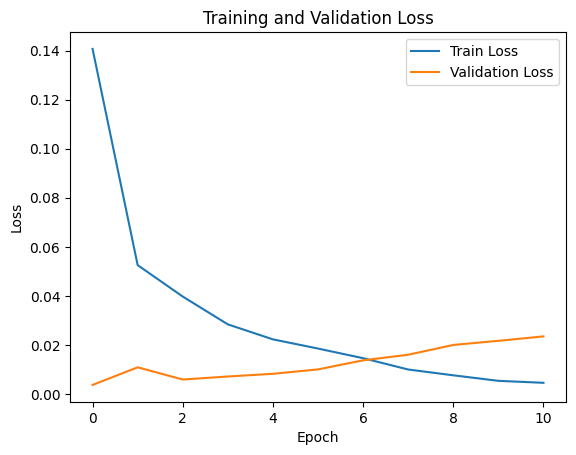

In [24]:
# Plot the training history of the best model
# Plot the loss and validation loss over epochs for the best model
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Output the best model parameters
# Print the best hyperparameters found in the grid search
print(f"Best model parameters: Units={best_params[0]}, Layers={best_params[1]}, Dropout={best_params[2]}, Learning Rate={best_params[3]}, Batch Size={best_params[4]}")

Best model parameters: Units=150, Layers=2, Dropout=0.2, Learning Rate=0.0001, Batch Size=48


In [26]:
#best_model.save('LL Prediction 1.h5')

### Testing Part

#### 1) Load the model

In [27]:
best_model

<Sequential name=sequential_191, built=True>

#### 2) Window sampling for testing set

In [28]:
import numpy as np

# Parameters for window sampling
input_window_size = 28
output_window_size = 1
stride = 1

# Initialize lists to store the input (X_test) and output (y_test) sequences for testing set
X_test, y_test = [], []

# Loop through the testing set to create windows of input and output sequences
for i in range(0, len(testing_set) - input_window_size - output_window_size + 1, stride):
    # Define the input window (20 data points)
    input_window = testing_set.iloc[i:i+input_window_size][['Latitude']]
    # Define the output window (1 data point immediately following the input window)
    output_window = testing_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Latitude']]
    # Append the input window to X_test and the last value of output window to y_test
    X_test.append(input_window.values)
    y_test.append(output_window.values[-1])

# Convert X_test and y_test lists to numpy arrays for model input
X_test, y_test = np.array(X_test), np.array(y_test)

# Print the number of samples created for testing
print(f"Number of test samples: {X_test.shape[0]}")
print(f"Test input shape: {X_test.shape}, Test target shape: {y_test.shape}")

Number of test samples: 648
Test input shape: (648, 28, 1), Test target shape: (648, 1)


#### 3) Test the Testing Set Using the Imported Model

In [29]:
best_model

<Sequential name=sequential_191, built=True>

In [30]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


#### 4) Calculate Error on the Testing Set

In [31]:
y_test

array([[0.72558625],
       [0.72657459],
       [0.72963532],
       [0.73151199],
       [0.73033511],
       [0.72818631],
       [0.72670491],
       [0.72576318],
       [0.72576338],
       [0.72576337],
       [0.72576342],
       [0.72576358],
       [0.72576253],
       [0.72631554],
       [0.72887283],
       [0.74114104],
       [0.7488761 ],
       [0.75656808],
       [0.76921204],
       [0.77696776],
       [0.78102901],
       [0.78571715],
       [0.78852959],
       [0.79065314],
       [0.79730607],
       [0.80505564],
       [0.81195722],
       [0.82089809],
       [0.82886427],
       [0.83810245],
       [0.84274481],
       [0.85046184],
       [0.85937814],
       [0.86253028],
       [0.86689806],
       [0.8751615 ],
       [0.88561521],
       [0.89602931],
       [0.90758665],
       [0.91451102],
       [0.92664169],
       [0.93359652],
       [0.94114814],
       [0.9507044 ],
       [0.95704071],
       [0.96354469],
       [0.96932753],
       [0.975

In [32]:
y_pred

array([[0.6331206 ],
       [0.63833505],
       [0.64311945],
       [0.6474989 ],
       [0.6515081 ],
       [0.65513587],
       [0.6583895 ],
       [0.6612529 ],
       [0.66374296],
       [0.66589695],
       [0.6677545 ],
       [0.6693377 ],
       [0.6706665 ],
       [0.67177814],
       [0.67269945],
       [0.6734817 ],
       [0.67433286],
       [0.67534965],
       [0.676597  ],
       [0.6782042 ],
       [0.680193  ],
       [0.6825238 ],
       [0.6851341 ],
       [0.68798983],
       [0.6910421 ],
       [0.6943056 ],
       [0.69779235],
       [0.70149446],
       [0.7054395 ],
       [0.70963144],
       [0.7140832 ],
       [0.7187222 ],
       [0.72355455],
       [0.7286119 ],
       [0.73381597],
       [0.739109  ],
       [0.74450344],
       [0.7500392 ],
       [0.75575316],
       [0.76169074],
       [0.7678136 ],
       [0.7741679 ],
       [0.7807019 ],
       [0.78737   ],
       [0.7941111 ],
       [0.8009134 ],
       [0.80774176],
       [0.814

In [33]:
from sklearn.metrics import mean_squared_error

# Calculate MSE between predicted and actual values
error = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Testing Set: {error}")

Mean Squared Error on the Testing Set: 0.005227927927141098


In [34]:
# Get the original data for predicted cells and add it to testing set as a new column
# Convert predictions to a DataFrame for easier concatenation
predictions_df = pd.DataFrame(y_pred, columns=['Predicted_Latitude'])

In [35]:
predictions_df.head()

,Predicted_Latitude
0,0.633121
1,0.638335
2,0.643119
3,0.647499
4,0.651508


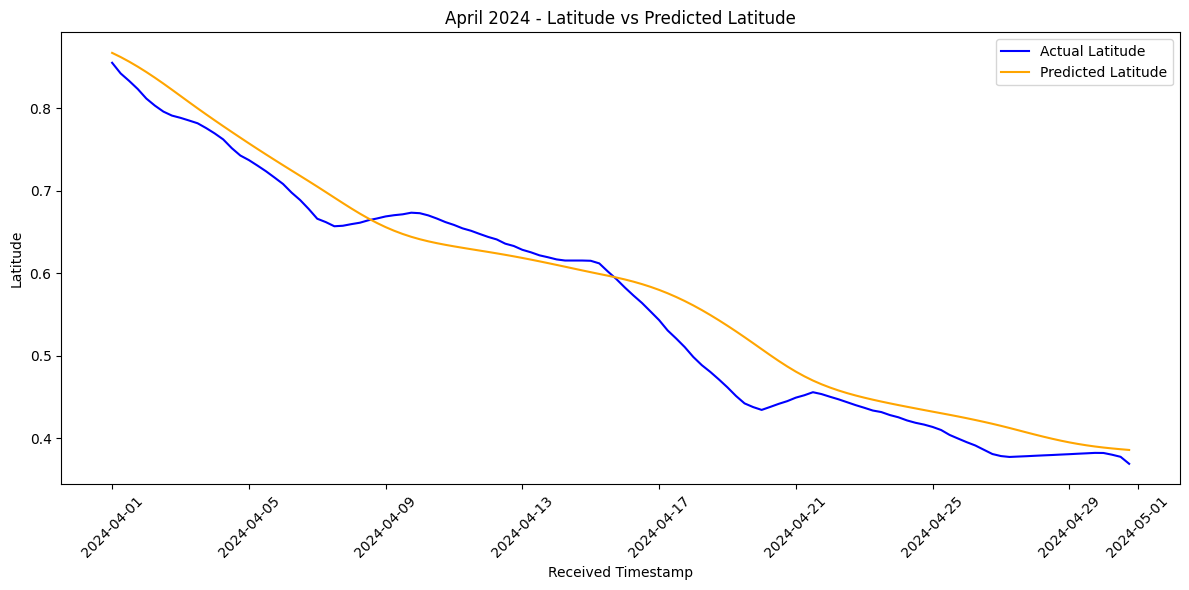

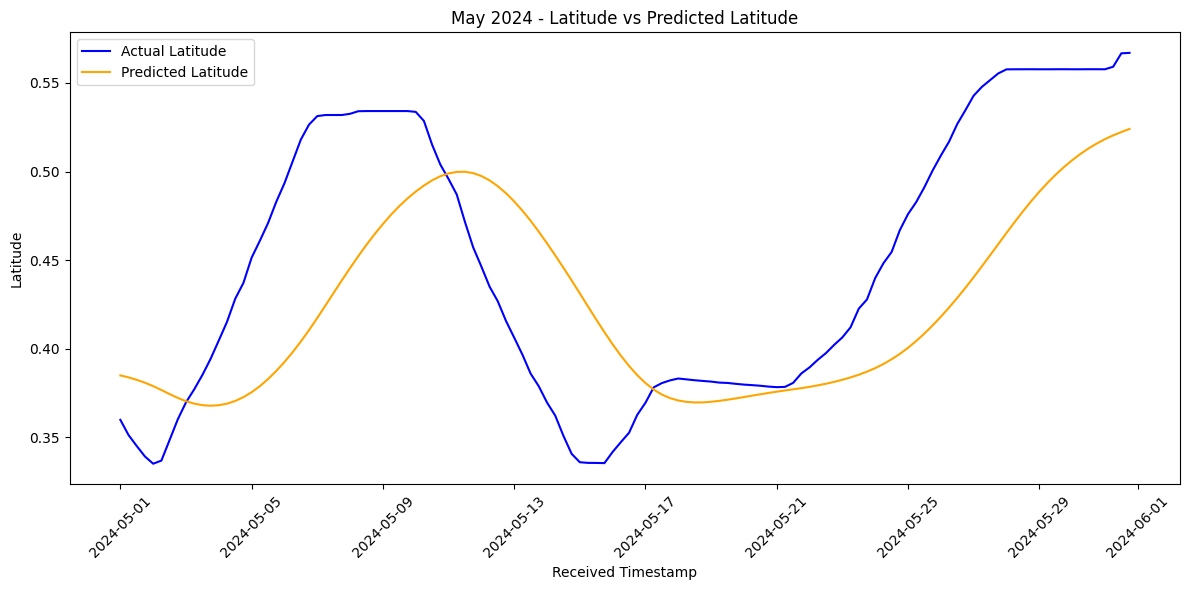

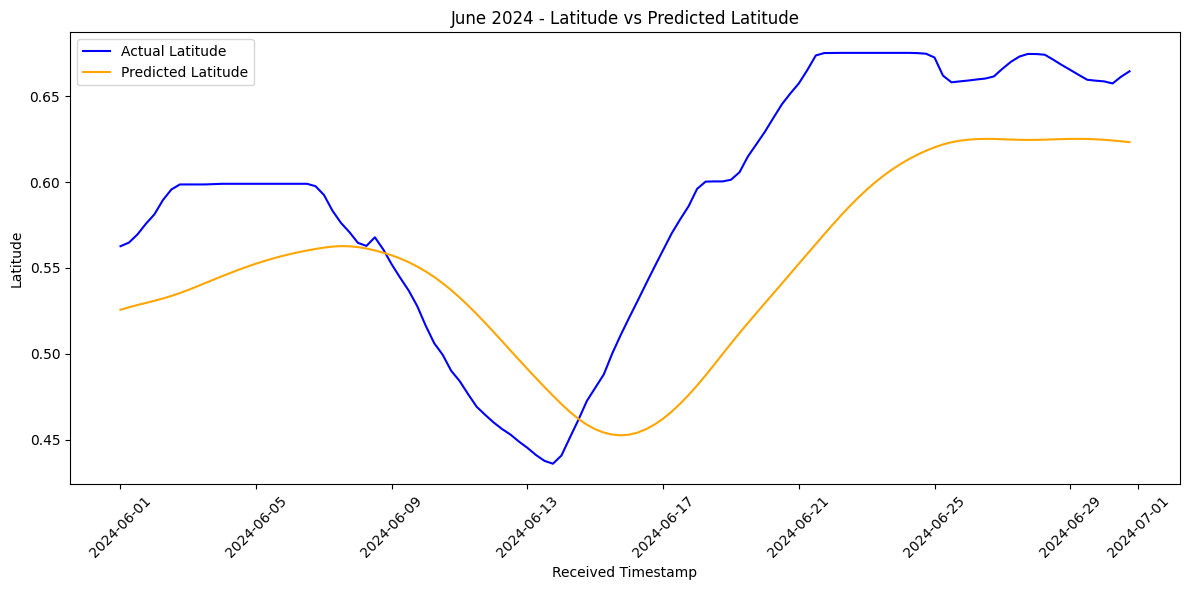

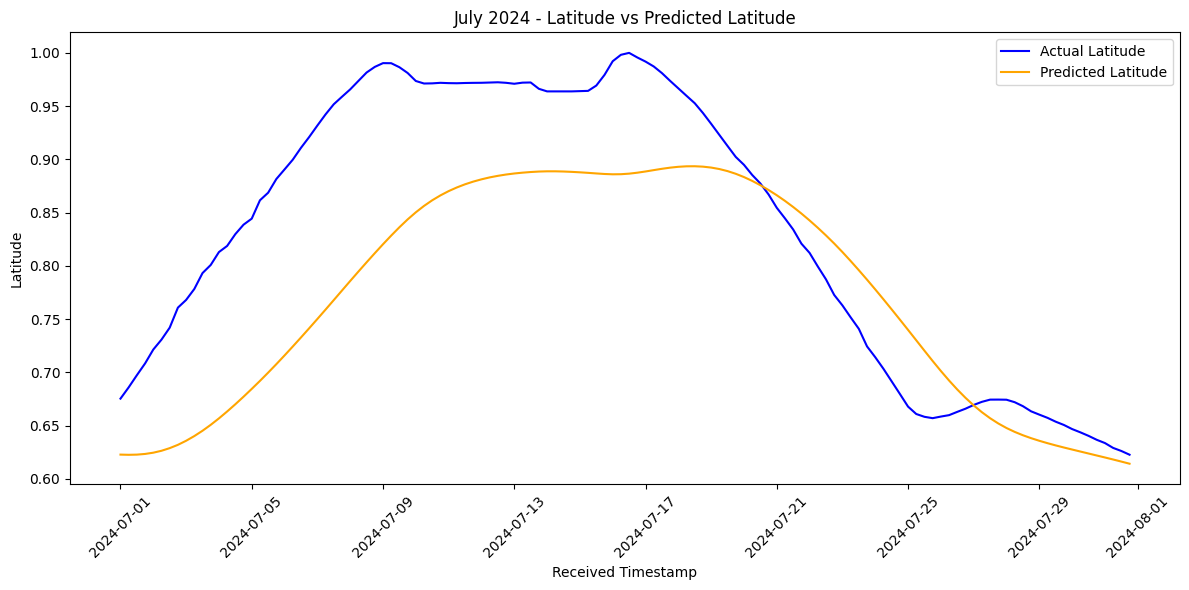

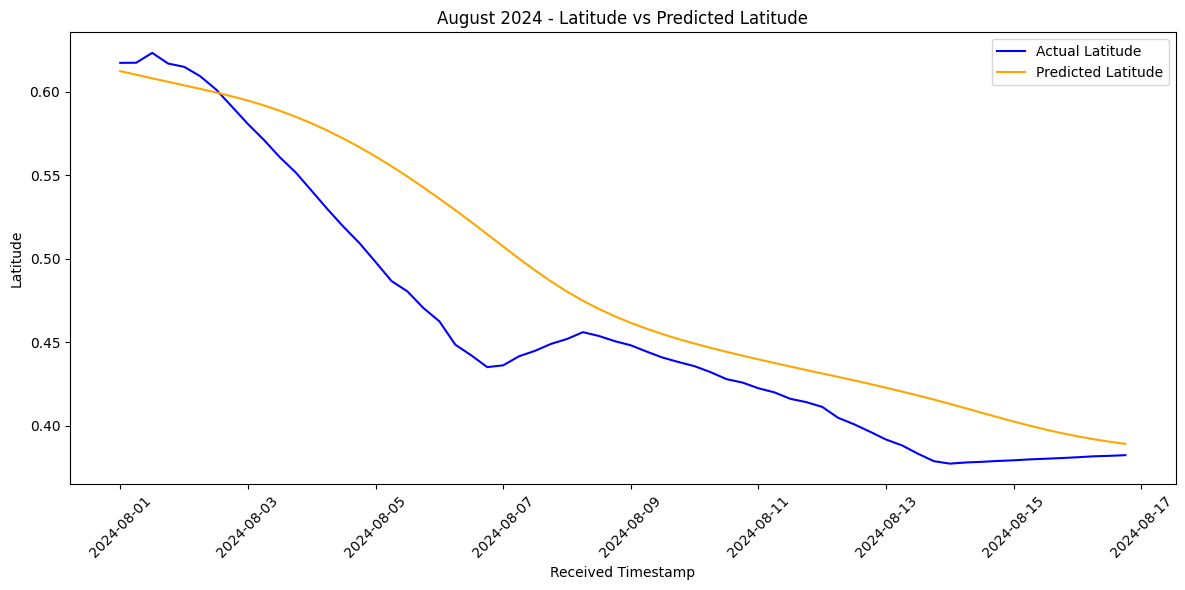

In [36]:
# Convert the predictions (y_pred) into a DataFrame for easy handling with timestamps
# We assume `testing_set.index[input_window_size:]` matches the `y_pred` in length
predicted_latitudes = pd.DataFrame(y_pred, index=testing_set.index[input_window_size:], columns=['Predicted_Latitude'])

# Add the 'Latitude' column from `testing_set` as the true values for comparison
testing_latitudes = testing_set[['Latitude']].iloc[input_window_size:]  # Skip initial window

# Define the months for filtering and specific timestamps for illustration
months = {
    'April': '2024-04',
    'May': '2024-05',
    'June': '2024-06',
    'July': '2024-07',
    'August': '2024-08'
}

# Plot each month's data
for month_name, month_str in months.items():
    # Filter data for the entire month
    monthly_actual_data = testing_latitudes[testing_latitudes.index.to_period('M') == month_str]
    monthly_predicted_data = predicted_latitudes[predicted_latitudes.index.to_period('M') == month_str]
    
    # Plot actual vs predicted latitude values for the month
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_actual_data.index, monthly_actual_data['Latitude'], label='Actual Latitude', color='blue')
    plt.plot(monthly_predicted_data.index, monthly_predicted_data['Predicted_Latitude'], label='Predicted Latitude', color='orange')
    
    # Formatting the plot
    plt.title(f'{month_name} 2024 - Latitude vs Predicted Latitude')
    plt.xlabel('Received Timestamp')
    plt.ylabel('Latitude')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [44]:
y_test_real = scaler.inverse_transform(y_test)
#y_test = y_test.reshape(-1, 1)  # Reshape if necessary
#y_pred = y_pred.reshape(-1, 1)  # Reshape if necessary

In [45]:
y_test_real

array([[43.35159583],
       [43.45832292],
       [43.7888413 ],
       [43.99149707],
       [43.86440981],
       [43.63236696],
       [43.4723963 ],
       [43.37070163],
       [43.37072329],
       [43.3707224 ],
       [43.37072714],
       [43.37074457],
       [43.370631  ],
       [43.43034859],
       [43.70650296],
       [45.0313069 ],
       [45.86659   ],
       [46.69722211],
       [48.06260219],
       [48.90011746],
       [49.33867801],
       [49.84493545],
       [50.14864124],
       [50.37795662],
       [51.09638489],
       [51.93323515],
       [52.67851445],
       [53.64400981],
       [54.50425173],
       [55.5018527 ],
       [56.00316548],
       [56.83650273],
       [57.79934521],
       [58.13973374],
       [58.61139633],
       [59.50373793],
       [60.63259987],
       [61.75718468],
       [63.00522476],
       [63.75296456],
       [65.06291528],
       [65.81394522],
       [66.62941962],
       [67.66136946],
       [68.34560687],
       [69

In [46]:
y_pred_real = scaler.inverse_transform(y_pred)
y_pred_real

array([[33.36653  ],
       [33.929623 ],
       [34.446274 ],
       [34.919197 ],
       [35.35214  ],
       [35.74389  ],
       [36.095238 ],
       [36.40445  ],
       [36.67334  ],
       [36.905945 ],
       [37.10653  ],
       [37.277496 ],
       [37.420994 ],
       [37.541035 ],
       [37.640522 ],
       [37.724995 ],
       [37.81691  ],
       [37.92671  ],
       [38.061405 ],
       [38.23496  ],
       [38.449726 ],
       [38.70142  ],
       [38.983303 ],
       [39.29168  ],
       [39.62129  ],
       [39.9737   ],
       [40.350224 ],
       [40.75     ],
       [41.176014 ],
       [41.62869  ],
       [42.109417 ],
       [42.61037  ],
       [43.1322   ],
       [43.678326 ],
       [44.240295 ],
       [44.81187  ],
       [45.3944   ],
       [45.99219  ],
       [46.609222 ],
       [47.2504   ],
       [47.91159  ],
       [48.597767 ],
       [49.303352 ],
       [50.023422 ],
       [50.751366 ],
       [51.485928 ],
       [52.2233   ],
       [52.95